# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

# Libraries Loading

In [1]:
%load_ext lab_black

In [7]:
%load_ext autoreload
%autoreload 2

In [1]:
import copy
import numpy as np
import os
import pandas as pd
from datetime import datetime
import sys
import pickle
import librosa
import librosa.display
from pathlib import Path
import numpy as np
from scipy.io import wavfile

import skorch
from skorch import callbacks
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.helper import predefined_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Subset

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# from keras.utils import np_utils

from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from speechpy.feature import mfcc

from keras.wrappers.scikit_learn import KerasClassifier

import IPython.display as ipd
from IPython.display import clear_output
from IPython.core.debugger import set_trace

sys.path.insert(1, "./src")
from misc_funcs import (
    MAIN_DIR,
    DATA_DIR,
    WAV_DIR,
    MFCC_DIR,
    MODEL_DIR,
    DE2EN,
    EN2DE,
    EN2NUM,
    NUM2EN,
    FULL_EM,
    DE2NUM,
    load_wav_data,
    get_mfcc,
    save_mfcc_data,
    load_mfcc_data,
    load_pd_data,
    SPEAKER_DATA,
)
from model import CNN_classif, train_model, run_model, get_LSTM, train_model_noval
from preprocess import data_augment, add_noise, add_pitch, add_shift
from visualisation import (
    plot_metrics,
    vis_sample,
    convert_history,
    plot_confusion_matrix,
)

sys.path.insert(1, "./lib/pytorch-cnn-visualizations/src/")
from generate_class_specific_samples import ClassSpecificImageGeneration

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'
COLOR_PALETTE = ["#f9ed69", "#f08a5d", "#b83b5e", "#00adb5", "#6a2c70", "#393e46"]

ModuleNotFoundError: No module named 'librosa'

# Data Preparation & Cleaning

## Wav length 

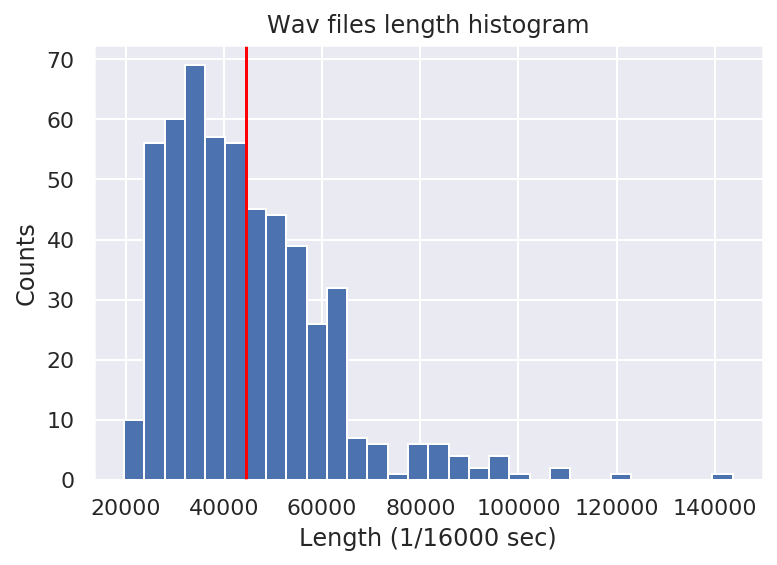

In [83]:
data_df['len'] = data_df.data.apply(len)
mean = data_df.len.mean()
data_df.len.hist(bins=30)
plt.title('Wav files length histogram')
plt.xlabel('Length (1/16000 sec)')
plt.ylabel('Counts')
plt.axvline(x=mean,color='red')

<div class="alert alert-block alert-info">
As we can see, most of the data is centered around the mean, despite a few outliers around 140000.
</div>

## Sex 

In [34]:
data_df.sex.value_counts()

female    302
male      233
Name: sex, dtype: int64

<div class="alert alert-block alert-info">
The dataset looks pretty balanced in terms of sex.
</div>

## Emotion Types

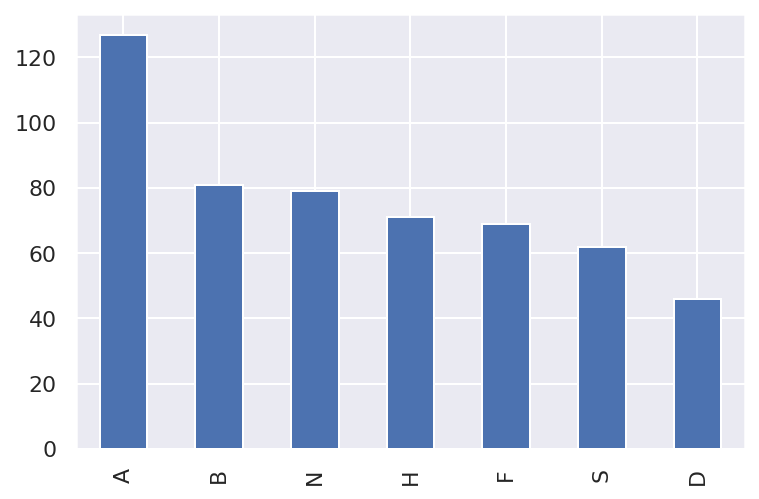

In [38]:
data_df.emotion.value_counts().plot.bar()

<div class="alert alert-block alert-info">
A small unbalance is present: this motivates us to normalize these during the data augmentation phase, in order to make the accuracy a valid metric
</div>

## Sex-emotion imbalance 

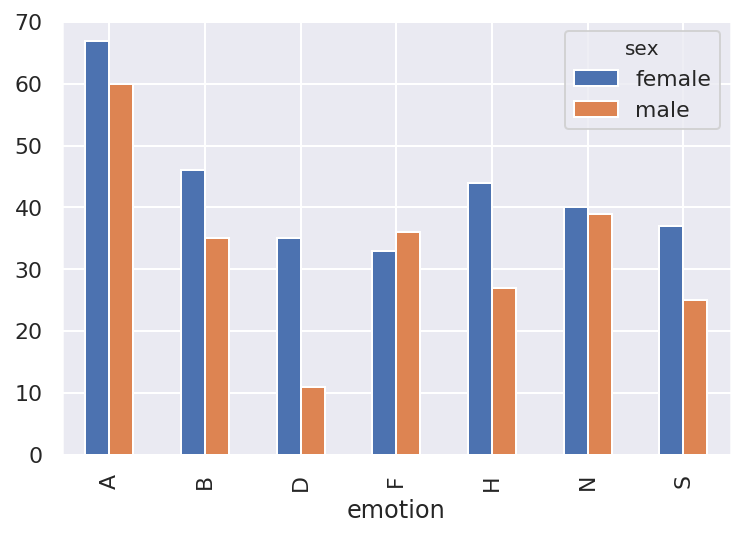

In [64]:
emo_sex = data_df.groupby(['emotion','sex'])['len']\
         .count()\
         .to_frame()\
         .reset_index(level=1)\
         .pivot(columns='sex',values='len')

emo_sex.plot.bar()

<div class="alert alert-block alert-info">
The sex bias looks acceptable: indeed, if a strong imbalance was present in the dataset amongst emotion (say for instance that the fear was acted mostly by men and the anger by women) this could have lead the models to learn the wrong features: i.e to recognize the sex instead of the emotions.
</div>

In [10]:
# we first load the wav data as a numpy array
file_names, sfs, data, targets = load_wav_data()
# and use its mfcc structure
data_f = get_mfcc(data, sfs)
# save it for quicker load the next time
save_mfcc_data(file_names, data_f, targets)

Saving done!


<div class="alert alert-block alert-info">
We use the mfcc as feature (state of the art features for speech recognition)
</div>

# Feature Engineering & Modeling

<div class="alert alert-block alert-info">
As the network was able to overfit the train set but performed poorly on the validation, we use data augmentation. More precisely, 3 types of them:
    
* Shift audio
* White Noise Addition
* Pitch Addition
</div>

In [22]:
def listen2sample(x, y):
    print(FULL_EM[NUM2EN[y]])
    librosa.display.waveplot(x)
    return ipd.Audio(x, rate=16000)

Fear


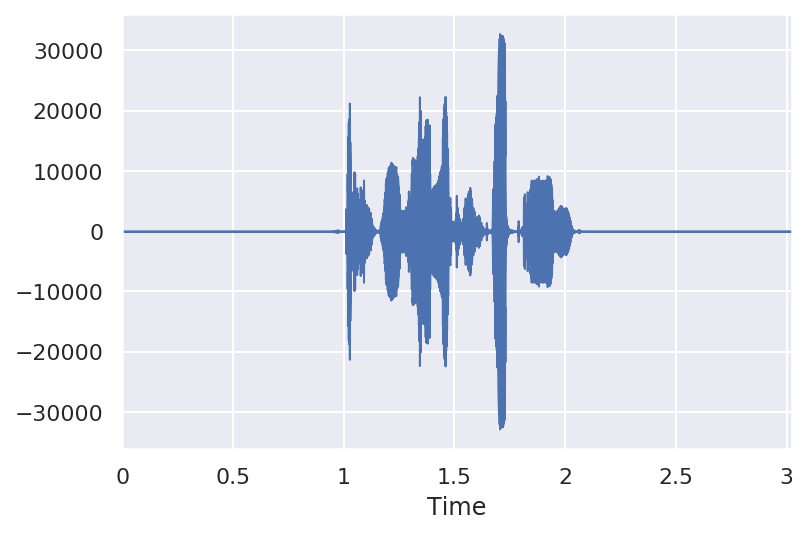

In [12]:
num = 55
listen2sample(data[num], targets[num])

Fear


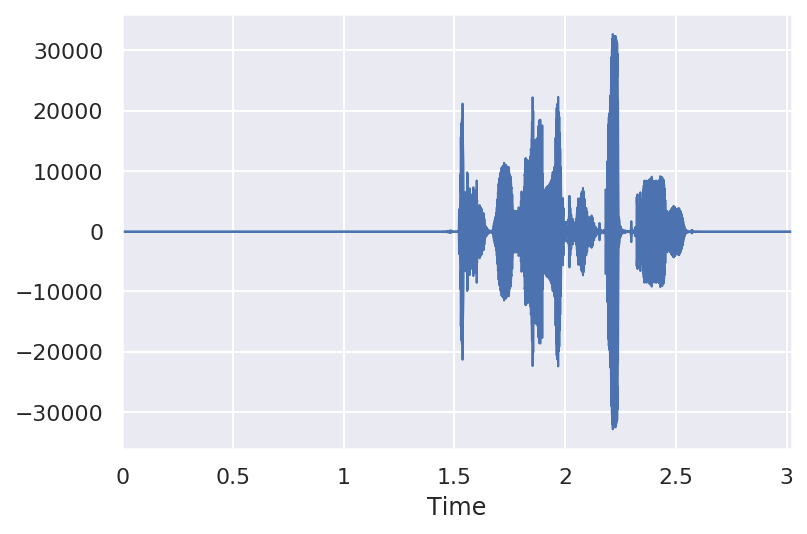

In [12]:
shifted = add_shift(data[num:num+1])[0]
listen2sample(shifted,targets[num])

Fear


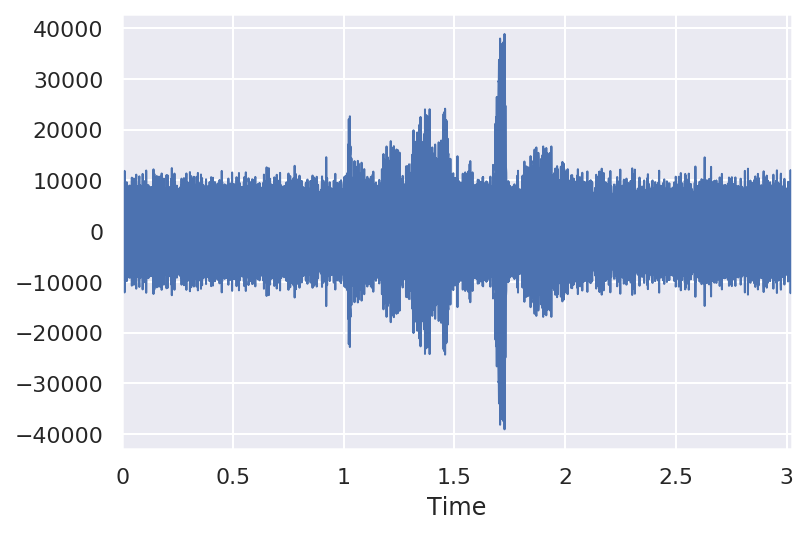

In [8]:
noised = add_noise(data[num:num+1])[0]
listen2sample(noised,targets[num])

Fear


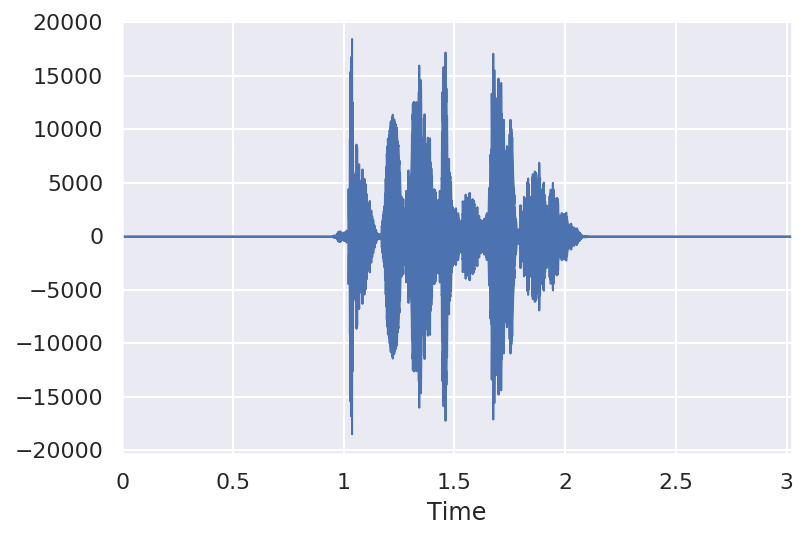

In [13]:
pitched = add_pitch(data[num:num+1])[0]
listen2sample(pitched,targets[num])

### Grid Search CNN

<div class="alert alert-block alert-info">
Hyper parameters optimization is handled thanks to classic grid search.
</div>

In [14]:
#precomputed GriSearch
with open("models/GridSearch_CNN1.pkl", "rb") as f:
    gs = pickle.load(f)

In [ ]:
file_names, sfs, data, targets = load_wav_data()
X_train,X_test,y_train,y_test = train_test_split(data,targets,test_size=0.2, random_state=14)
X_train,y_train = data_augment(X_train,y_train,True,True,True)
X_train = get_mfcc(X_train,sfs[0])
X_test = get_mfcc(X_test,sfs[0])

X_tot = np.concatenate((X_train,X_test))
y_tot = np.concatenate((y_train,y_test))
indxes = np.full(len(X_tot),0)
indxes[:len(X_train)] = -1
ps = PredefinedSplit(indxes)

model = CNN_classif()

params = {
    "lr":np.logspace(-4,-1,4),
    "optimizer": [optim.SGD,optim.Adam,optim.AdamW],
    "criterion":[nn.CrossEntropyLoss,nn.NLLLoss]
}
call1 = EpochScoring(on_train=True, lower_is_better=False, scoring=accuracy_score)
net_gs = NeuralNetClassifier(model.double(), max_epochs=8,batch_size=20,callbacks=[call1])
gs = GridSearchCV(net_gs, params, refit=False, cv=ps, scoring="accuracy", verbose=2,)

In [ ]:
gs.fit(X_tot,y_tot)

In [ ]:
#saving
with open("models/GridSearch_CNN.pkl",'wb') as f:
    pickle.dump(gs)

### Best Model CNN

<div class="alert alert-block alert-info">
We train further the best parameters computed thanks to the grid-search.
</div>

In [29]:
file_names, sfs, data, targets = load_wav_data()
random_state = 12
X_train, X_test, y_train, y_test = train_test_split(
    data, targets, test_size=0.2, random_state=random_state
)
X_train, y_train = data_augment(
    X_train, y_train, rndom_noise=True, shift=True, pitch=True, ratio=0.8
)
X_train = get_mfcc(X_train, sfs[0])
X_test = get_mfcc(X_test, sfs[0])

dataset_train = skorch.dataset.Dataset(X_train, y_train)
dataset_val = skorch.dataset.Dataset(X_test, y_test)

model = CNN_classif()
call1 = EpochScoring(on_train=True, lower_is_better=False, scoring=accuracy_score)
call2 = callbacks.Checkpoint(
    monitor="valid_acc_best",
    f_params="models/{}NN_classparams.pkl".format(random_state),
    f_optimizer="models/{}NN_opt.pkl".format(random_state),
    f_history="models/{}NN_hist.json".format(random_state),
)

net = NeuralNetClassifier(
    model.double(),
    batch_size=20,
    max_epochs=33,
    lr=4e-4,
    train_split=predefined_split(dataset_val),
    optimizer=optim.AdamW,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    callbacks=[call1, call2],
)

In [30]:
net.fit(dataset_train, y=None)

  epoch    accuracy_score    train_loss    valid_acc    valid_loss    cp       dur
-------  ----------------  ------------  -----------  ------------  ----  --------
      1            0.3996        1.5695       0.3645        1.4686     +  138.3662
      2            0.5585        1.1378       0.3925        1.6351     +  144.7596
      3            0.6348        0.9384       0.5888        1.1056     +  159.5405
      4            0.7166        0.7639       0.5794        1.0623        142.2499


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNN_classif(
    (convblock1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(13, 13), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(13, 13), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (convblock3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(13, 13), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock4): Sequential(
      (0): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (

In [14]:
net.save_params(
    f_params="models/{}NN_classparams.pkl".format(random_state),
    f_optimizer="models/{}NN_opt.pkl".format(random_state),
    f_history="models/{}NN_hist.json".format(random_state),
)

# Results & Visualizations

## CNN

In [7]:
instance = CNN_classif()
net = NeuralNetClassifier(instance.double())
net.initialize()
net.load_params(
    f_params="models/14NN_classparams.pkl",
    f_optimizer="models/14NN_opt.pkl",
    f_history="models/14NN_hist.json",
)

### Train-Validation Metrics

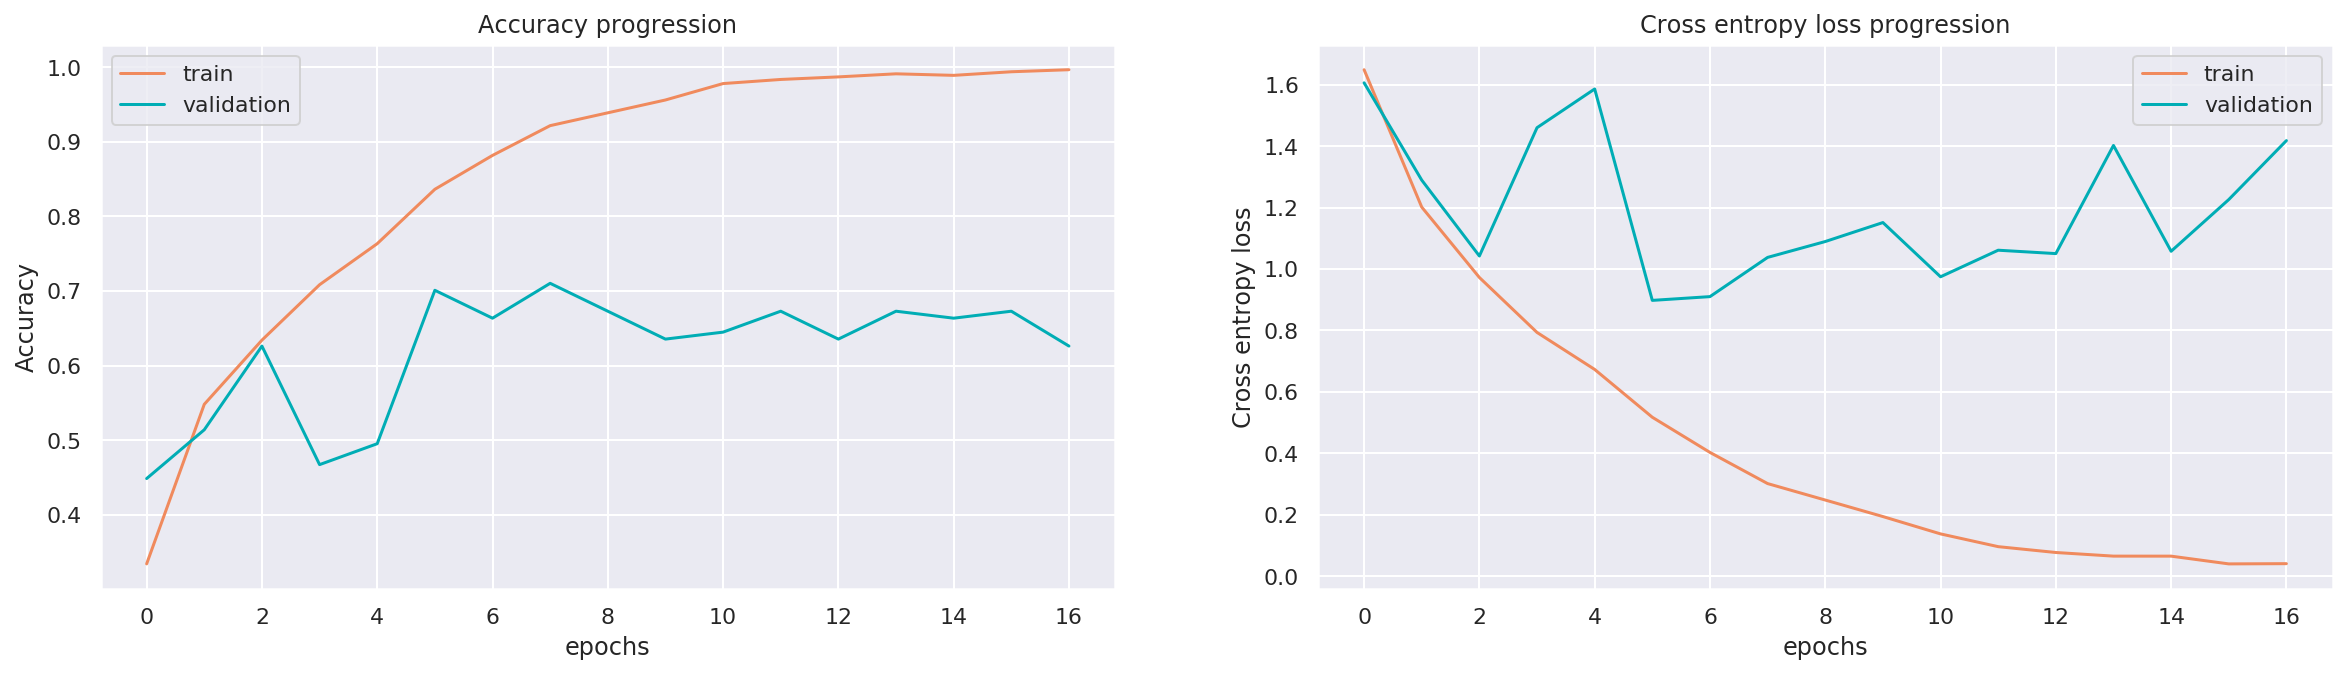

In [15]:
plot_metrics(net.history_[:-1])

### Confusion Matrix

In [16]:
# make sure the random_state is the same as when the network was trained
file_names, sfs, data, targets = load_wav_data()
X_train, X_test, y_train, y_test = train_test_split(
    data, targets, test_size=0.2, random_state=13
)
X_test_f = get_mfcc(X_test, sfs[0])

In [17]:
y_pred = net.predict_proba(X_test_f)
y_pred = np.argmax(y_pred, 1)
conf = confusion_matrix(y_test, y_pred)

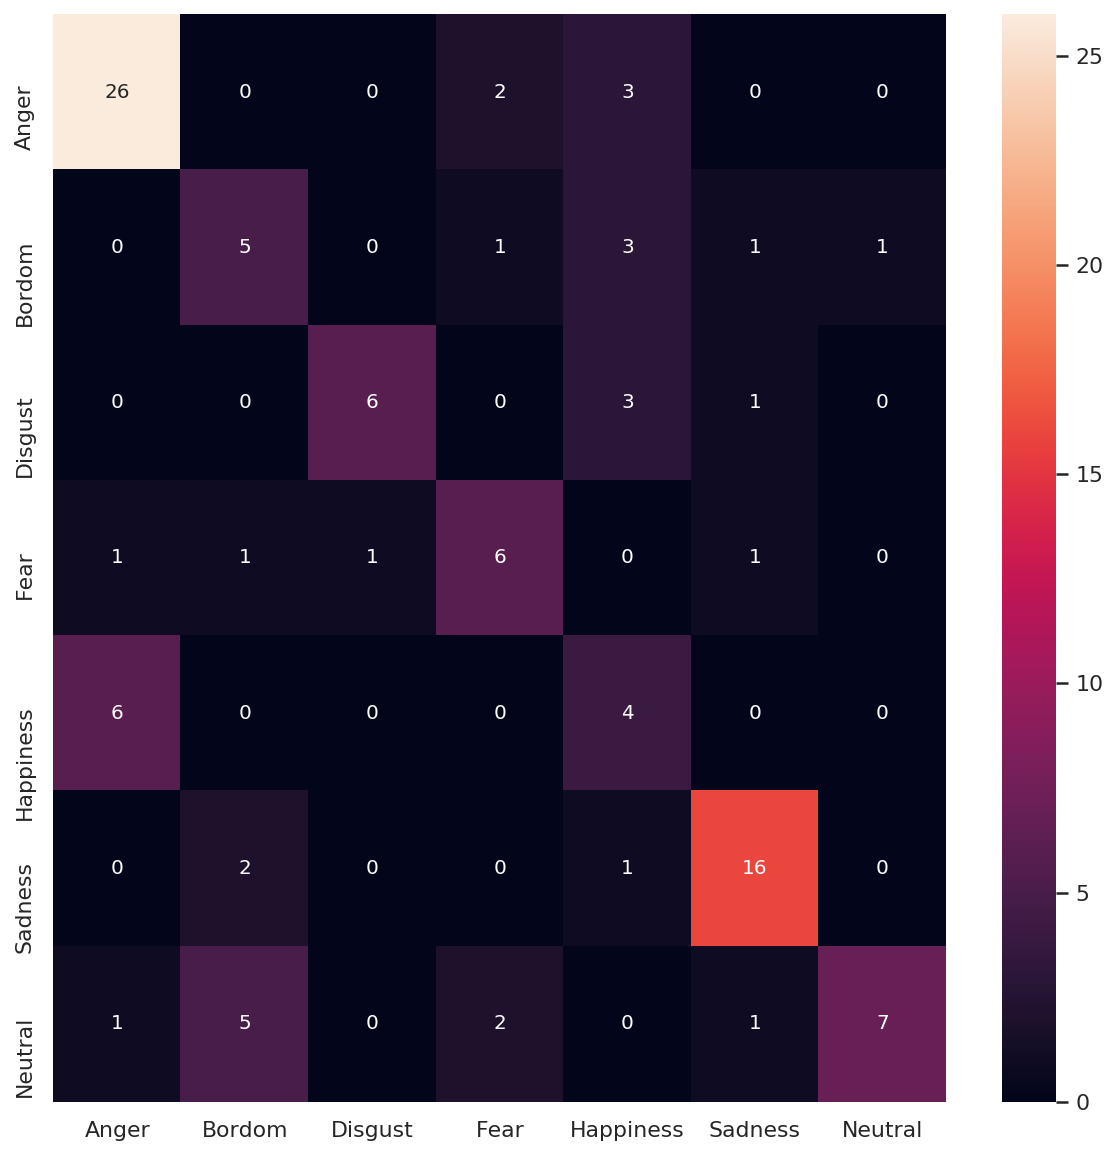

In [18]:
plot_confusion_matrix(conf)

In [20]:
mask_bor_misclass = (y_pred != y_test) & (y_test == EN2NUM["B"])
mask_hap_misclass = (y_pred != y_test) & (y_test == EN2NUM["H"])

Bordom


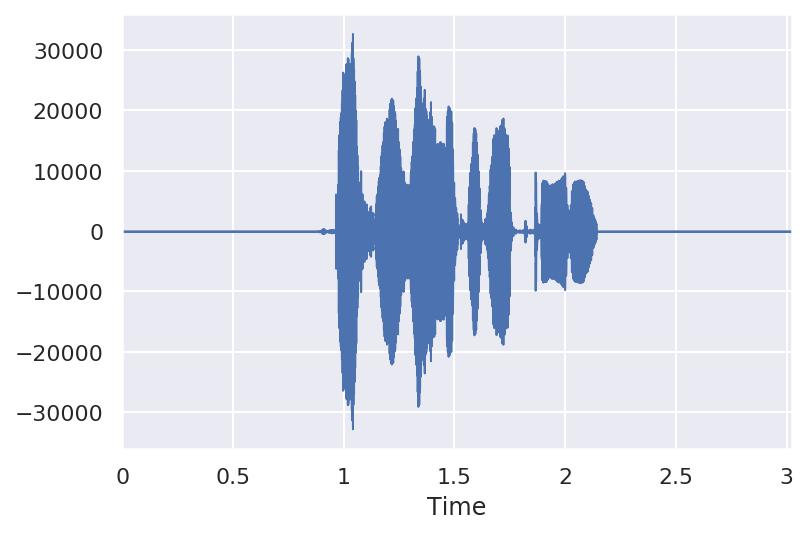

In [23]:
listen2sample(X_test[mask_bor_misclass][0], EN2NUM["B"])

Happiness


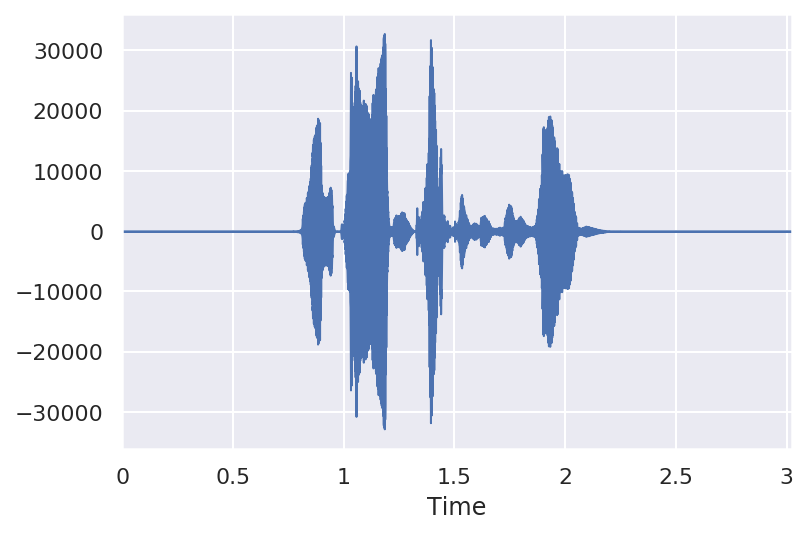

In [24]:
listen2sample(X_test[mask_hap_misclass][0], EN2NUM["H"])

### Max Image Activation

<div class="alert alert-block alert-info">
As we use CNN and perform decently, it becomes potentially possible to perform some feature visualization, in our case to visualize which image input stimulates the most a given output class. This is done by performing gradient descent on the pixels values and defining the loss function as the negative output value of a given label in the final layer.
    
Ideally, this should generate an image which represent well the class of corresponding images (sounds in our case) if the network has indeed reached a decent validation accuracy.
</div>

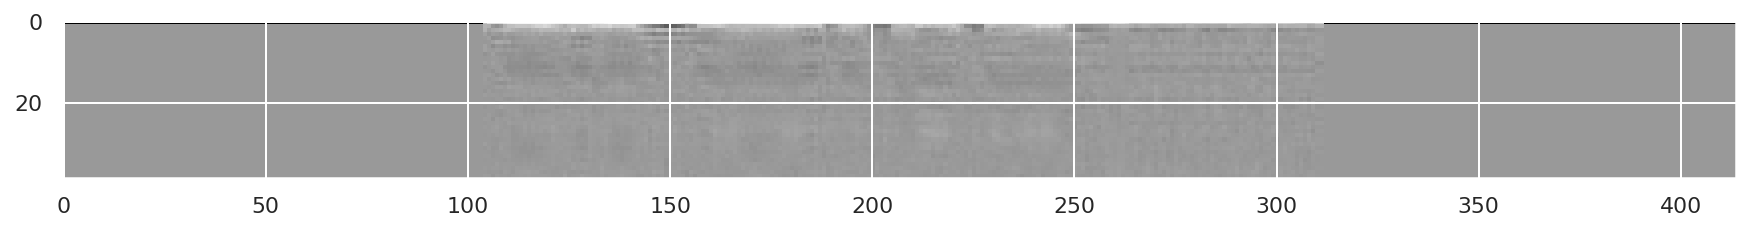

In [25]:
vis_sample(X_test_f[0, 0])

In [49]:
results = []
for i in range(7):
    print("Image {} on 7".format(i))
    csig = ClassSpecificImageGeneration(net.module.float().eval(), i)
    result = csig.generate(iterations=150)
    result = result[0, 0].detach().numpy()
    results.append(result)

Image 0 on 7
Image 1 on 7
Image 2 on 7
Image 3 on 7
Image 4 on 7
Image 5 on 7
Image 6 on 7


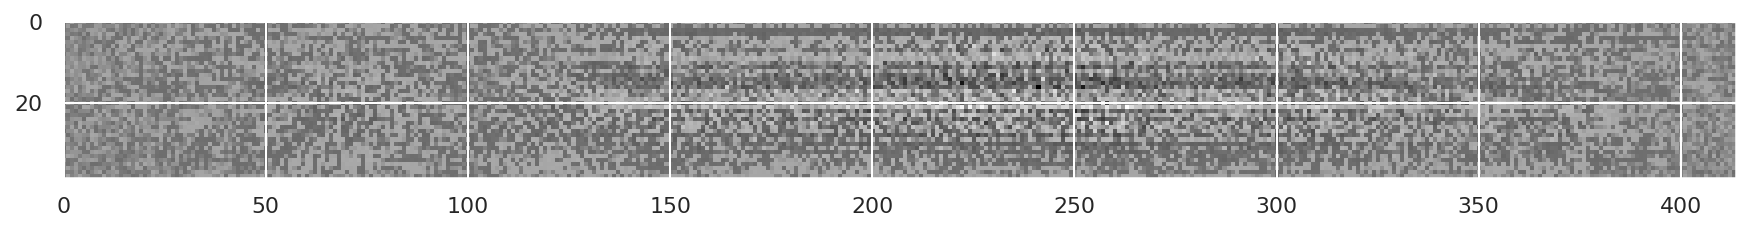

In [56]:
i = 6
vis_sample(results[0],FULL_EM[NUM2EN[i]])

<div class="alert alert-block alert-info">
Two problems were encountered: first, the chosen library does not allow for reverse mfcc transforms. Then, the network did not reach a high enough validation accuracy to generate meaningful images. Due to time constraints, this part of the project was no longer developped. 
</div>